<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/2023_DB_DS_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RB DS exercise

## Problem statement

Our client is a private dental clinic chain with a current network of 71 stores in France. The aim of this project is to understand what drives **center performance** and more precisely identify to what extent it is driven by **internal factors** such as quality of service or by **external factors** such as number of patients in the catchment area.

Therefore our team of consultants and data scientists has gathered **data on the clients' centers** and on the catchment areas surronding these centers. This data is available in the file attached *20231124_dental_center_data.xlsx*.

In order to solve this case please write your code in the cells below each question. Please feel free to add markdown cells to specify your reasoning and comment your code for easier understanding.

**Note: please make sure to use a version of Python > 3.9 and to import all the necessary packages in the cell right below**

In [3]:
# import your packages here
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,LeaveOneOut,GridSearchCV,ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error as MSE,make_scorer,silhouette_score
from xgboost import XGBRegressor

from sklearn.cluster import SpectralClustering

from pyproj import Transformer
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
# check your python version
!python -V

Python 3.10.12


Goal : The aim of this project is to understand what drives center performance and more precisely identify to what extent it is driven by internal factors such as quality of service or by external factors such as number of patients in the catchment area. <br>

Notes :

*   Que des variables quantitatives (int/float)
*   Ce n'est pas un probleme de regression ou de classification classique, on veut à la fois maximiser le revenue tout en assurant une marge conséquente
*   Pas beaucoup de données -> peu de variables dans nos modèles, pas de DL, enlever certaines variables peut être corrélées, Bootstrap Sampling ou CV, faire du feature engineering, data augmentation comme créer l'âge du centreou des ratios, modèles baysiens pour obtenir des incertitudes, stratifier les données, si plusieurs var correlées ne garder que celle qui possède le moins de valeur manquante
*    Avec ce dernier point, cela rend les données manquantes encore importantes -> Soit voir au cas par cas en intuitant un algo soit K-NN pour faire une moyenne avec ses clusters
*    Facteurs internes : revenue, r_margin (indicateurs de performance économique),
fte (effectif du personnel),
nbr_reviews, avg_rating (qualité perçue),
rent (coût de l’emplacement),
et l'Opening year (ancienneté)
*   Facteurs Externes : nbr_patients, patients_yearly_growth, patients_over_65,
median_revenue, r_unemployment, r_poverty (situation socio-économique),
ainsi que les densités
*   Les performances du cabinet pourront être expliquées par à la fois le revenu et r_margin -> Perf = α×log(revenue + jitter)+(1−α)×r_margin, α à adapter selon les objectifs du dentiste
*   Identifier quelles sont les variables qui sont importantes -> SHAP
*   A quoi cela sert d'afficher les plot de couples de variables pour voir leur relation ? particulierement pour nos variables target
*   Question de la pertinence d'utiliser R2 avec des arbres, est ce que en général c'est pertinent pour tout autre modele non lineaires ?




## Question 1

Inspect the data in the *20231124_dental_center_data.xlsx* file and **perform a descriptive data analysis**. Sample questions could be:
- Are there missing values?
- Are there outliers or unexpected values?
- Which variables are correlated, to what extend?
- ...

**Note: do not hesitate to use data vizualisation to support your findings**

- Some missing values -> K NN
- some unexepcted values (density negative, id 9), sinon some outliers mais pas problématiques, voir avec le
- density are correlated -> PCA
- Globalement des variables asser symetriques et homogenes
- quelques features asser skewed positivement : les taux poverty,  unemployment, patients over 65, revenue and median_revenue ->  transformation logarithmique ou Box-Cox

In [783]:
pd.read_excel('20231124_dental_center_data 1.xlsx').columns

Index(['ID', 'Latitude', 'Longitude', 'Revenue [21; EUR m]',
       'Margin rate [21; %]', 'Dentist FTE [#]',
       'Number of reviews on Google [#]', 'Average Google rating',
       'Rent in the area [EUR/sqm]', 'Patients in the catchment area [#]',
       'Patients' yearly growth in the catchment area [%]',
       'Share of patients in the catchment area over 65 [%]',
       'Median revenue in catchment area [EUR]',
       'Unemployment rate in the catchment area [%]',
       'Poverty rate in the catchment area [%]',
       'Density of doctors in the catchment area [#/100k patients]',
       'Density of pharmacists in the catchment area [ #/100k patients]',
       'Density of dentists in the catchment area [#/100k]', 'Opening year'],
      dtype='object')

In [74]:
# your code here
data = pd.read_excel('20231124_dental_center_data 1.xlsx').drop('ID', axis = 1)
# Densist FTE = full-time equivalent
columns_mapping = {
    'Dentist FTE [#]': 'fte',
    'Margin rate [21; %]': 'r_margin',
    'Revenue [21; EUR m]': 'revenue',
    'Number of reviews on Google [#]': 'nbr_reviews',
    'Average Google rating': 'avg_rating',
    'Rent in the area [EUR/sqm]': 'rent',
    'Patients in the catchment area [#]': 'nbr_patients',
    'Share of patients in the catchment area over 65 [%]': 'patients_over_65',
    'Unemployment rate in the catchment area [%]': 'r_unemployment',
    'Median revenue in catchment area [EUR]': 'median_revenue',
    'Poverty rate in the catchment area [%]': 'r_poverty',
    'Patients\' yearly growth in the catchment area [%]': 'patients_yearly_growth',
    'Density of doctors in the catchment area [#/100k patients]': 'density_doctors',
    'Density of pharmacists in the catchment area [ #/100k patients]': 'density_pharmacists',
    'Density of dentists in the catchment area [#/100k]': 'density_dentists'
}

data = data.rename(columns=columns_mapping)

data.head()

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
0,48.804336,2.420931,2.4,0.18,7.0,190.0,3.552632,5731,58874.899010,-0.24,13.060859,23330.857143,7.8,13.615055,133.0,66,104,2019
1,49.895083,2.298487,2.6,0.21,9.0,153.0,4.039216,2708,39687.660222,0.18,13.514219,19647.037037,9.6,20.113324,173.0,33,121,2019
2,43.578549,7.119384,3.3,0.21,10.0,163.0,4.288344,4751,25370.677794,-0.68,33.162485,22524.666667,12.5,15.142544,177.0,69,112,2018
3,43.655764,1.370467,2.2,0.09,10.0,145.0,4.158621,3205,6945.136108,1.83,10.971403,23213.333333,8.1,8.124205,179.0,89,116,2020
4,44.879637,-0.570372,2.9,0.21,8.0,63.0,4.650794,3707,6992.074760,1.08,9.078928,19480.000000,7.4,30.930467,182.0,76,121,2019


In [ ]:
print(data.isna().sum()/len(data)*100)
#bcp de null relativement à la taille du data set
#Se pose la question de est ce que ce n'est pas nul au lieu d'être Nan pour les features revenue,density_doctors,nbr_patients
#Abérrant pour les features : r_poverty,r_unemployment
#nbr_reviews et avg_rating ont exactement le même nombre de Nan

Latitude                  0.000000
Longitude                 0.000000
revenue                   7.042254
r_margin                  7.042254
fte                       7.042254
nbr_reviews               4.225352
avg_rating                4.225352
rent                      0.000000
nbr_patients              1.408451
patients_yearly_growth    0.000000
patients_over_65          0.000000
median_revenue            0.000000
r_unemployment            1.408451
r_poverty                 1.408451
density_doctors           2.816901
density_pharmacists       0.000000
density_dentists          0.000000
Opening year              0.000000
dtype: float64


In [ ]:
negative_values = (data < 0).sum()
print(negative_values) #valeur aberrante pour density

Latitude                   0
Longitude                  6
revenue                    0
r_margin                   4
fte                        0
nbr_reviews                0
avg_rating                 0
rent                       0
nbr_patients               0
patients_yearly_growth    34
patients_over_65           0
median_revenue             0
r_unemployment             0
r_poverty                  0
density_doctors            1
density_pharmacists        0
density_dentists           0
Opening year               0
dtype: int64


In [ ]:
nan_revenue = data[data['revenue'].isna()]

In [ ]:
nan_revenue #chercher une cause à pourquoi par renseigné : vient d'être crée ? Est fermé ? EN travaux en 2021 ? ou alors moyenne imputer ?
#iloc 37, on peut mettre tout à zero compte tenu qu'il a été crée en 2021 .. Pour les autres imputing !

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
17,48.736834,1.365297,NaN,NaN,NaN,19.0,4.578947,1590,16206.342013,-0.46,15.763840,17016.923077,7.2,24.174403,106.0,40,104,2016
20,49.023062,1.148888,NaN,NaN,NaN,10.0,4.700000,1844,17408.129904,-1.24,19.890533,18980.000000,8.1,15.407340,96.0,34,109,2019
29,48.959236,2.882169,NaN,NaN,NaN,33.0,4.060606,2870,23423.885548,0.61,13.688214,19556.153846,7.4,13.890370,100.0,44,78,2016
34,48.692024,6.181425,NaN,NaN,NaN,14.0,4.714286,2559,52741.353401,0.16,13.566230,21786.206897,7.8,17.647573,176.0,73,120,2018
37,43.838278,4.363345,NaN,NaN,NaN,NaN,NaN,1988,55887.755483,-0.12,21.732715,18604.666667,11.0,25.542045,150.0,72,114,2021


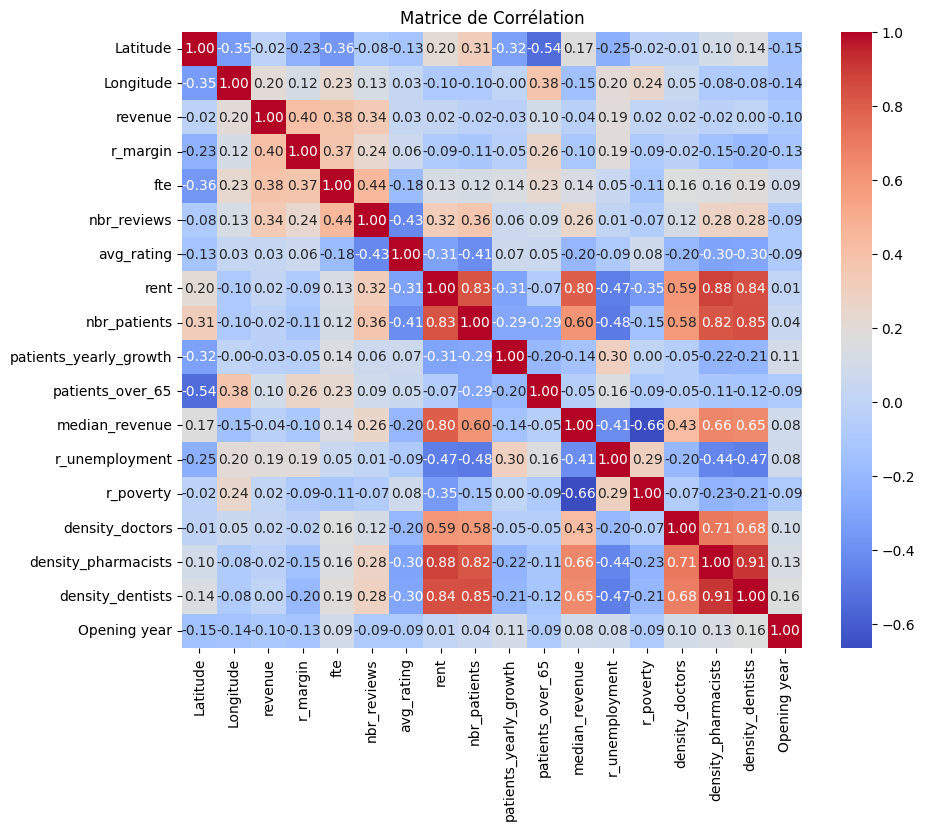

In [ ]:
# Correlation forte entre les densities -> PCA
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de Corrélation')
plt.show()

In [ ]:
#sns.set_theme(style="ticks")
#sns.pairplot(data)

On voit bien ici une relation quasi linéaire entre plusieurs variables. Par Exemple (rent,median revenue),(fte, revnue), (revenue, r_margin) ... Cela est important de regarder cela, pour éviter toute sorte de leakage sur la target, dans le cas ou une des features est fortemment correlées à la target. A vérifier.

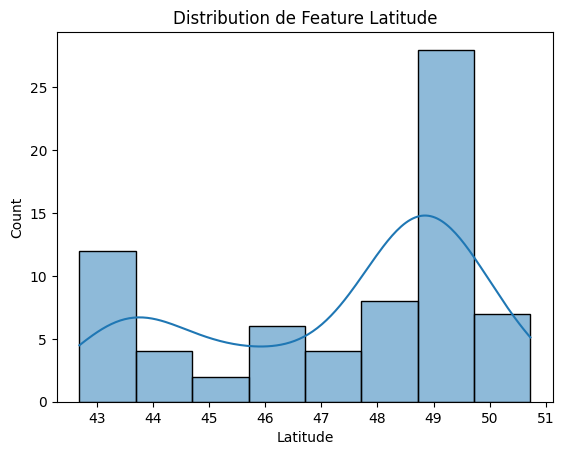

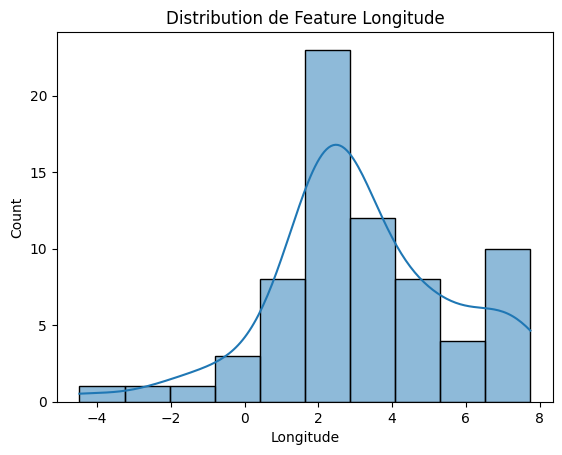

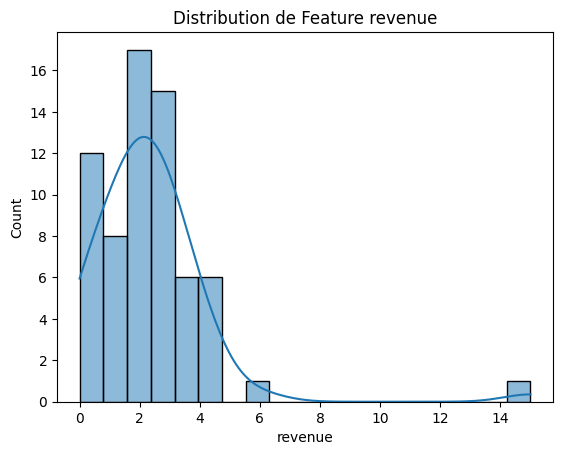

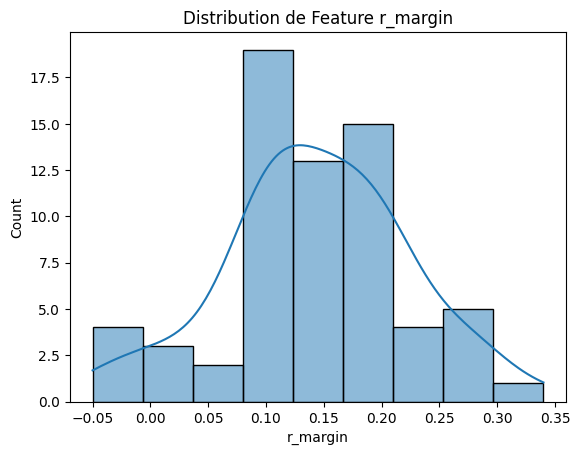

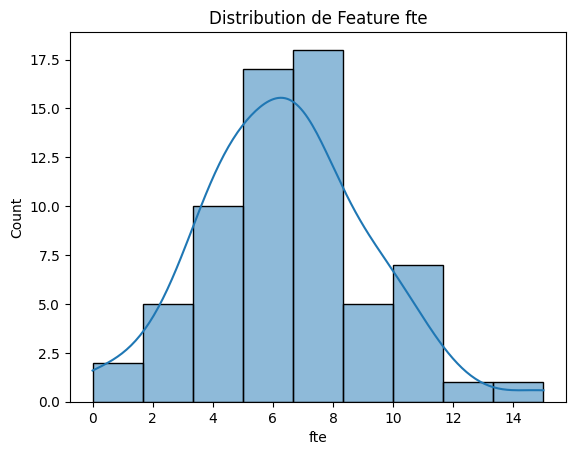

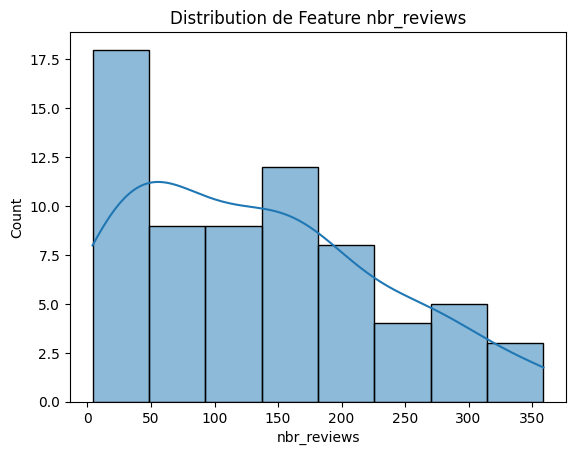

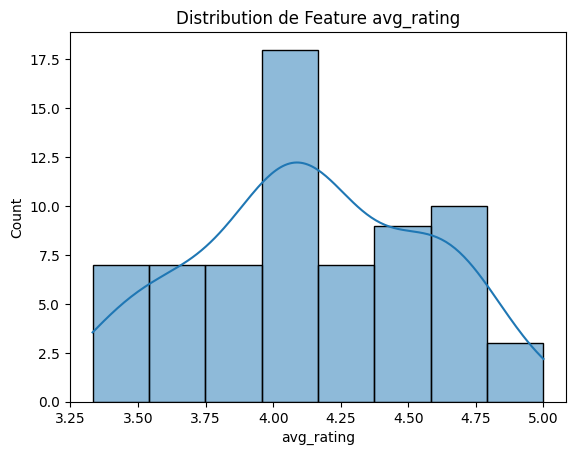

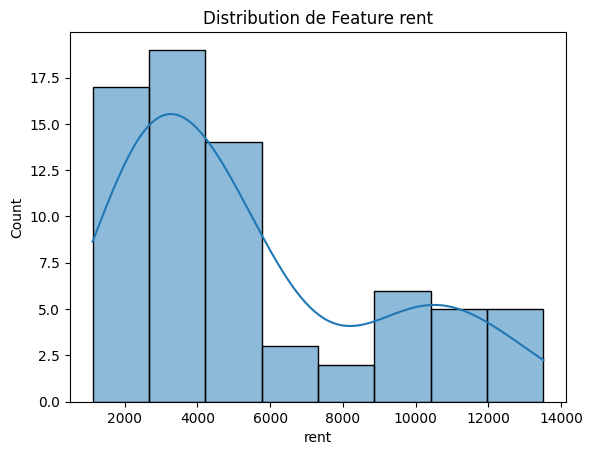

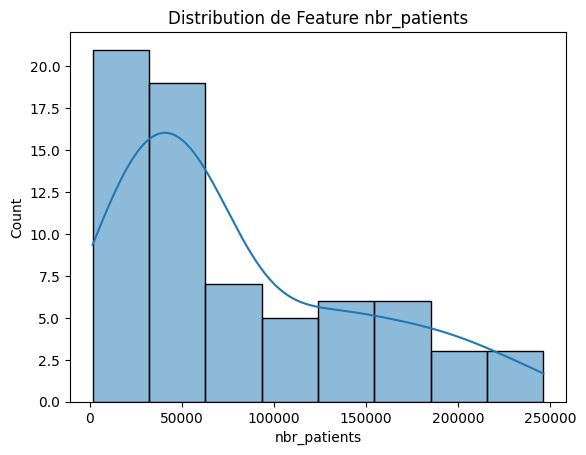

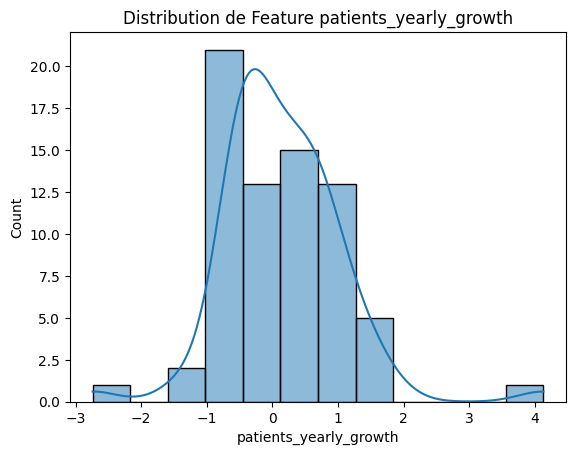

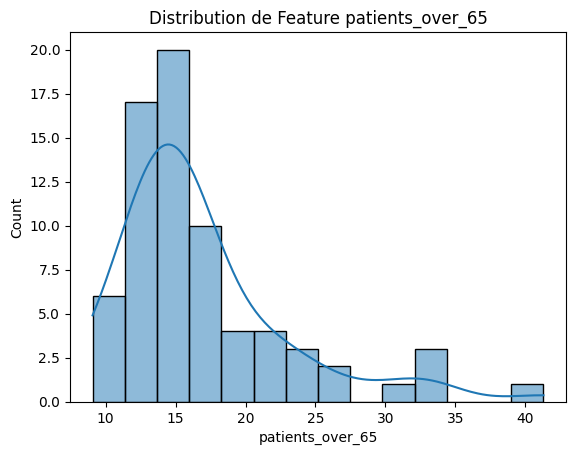

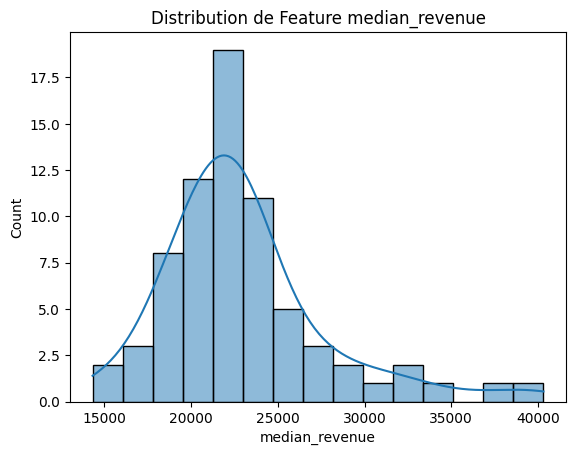

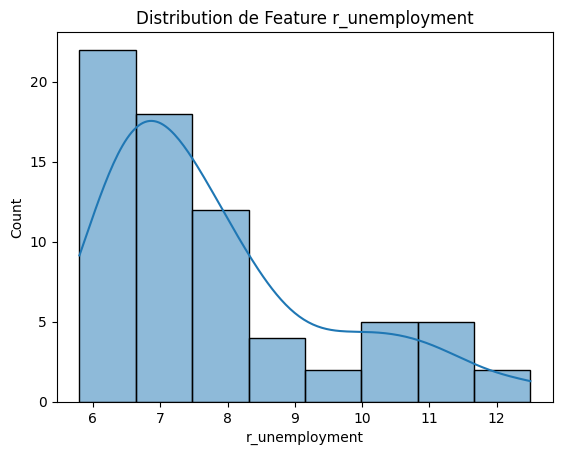

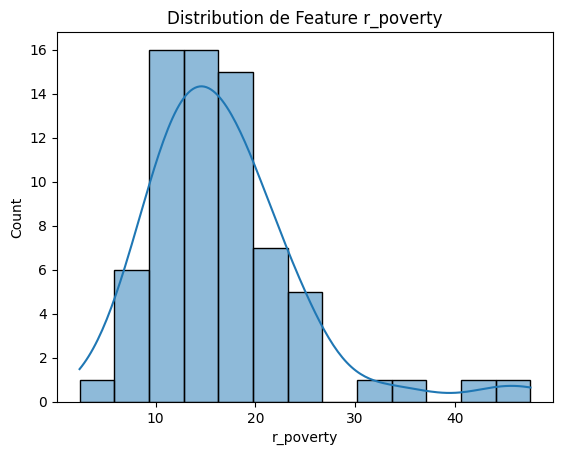

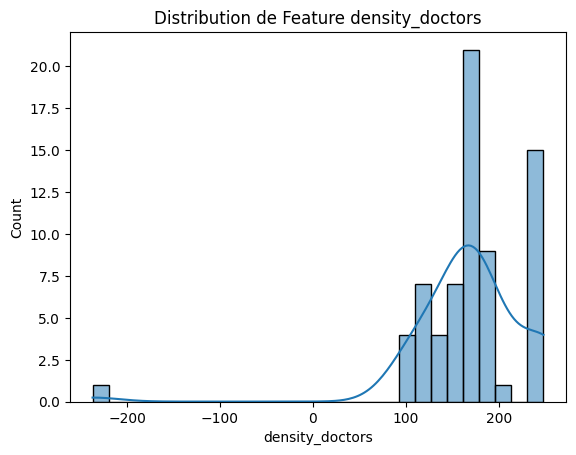

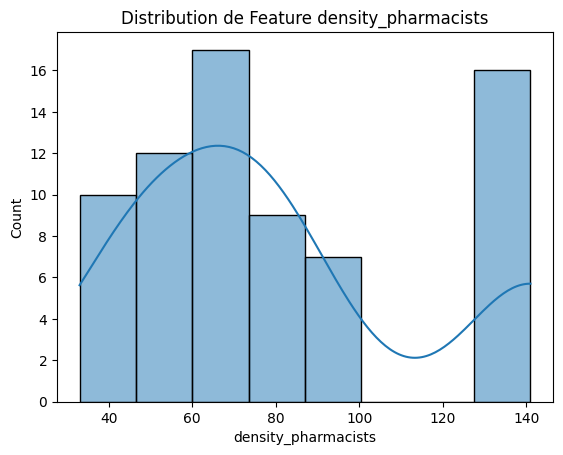

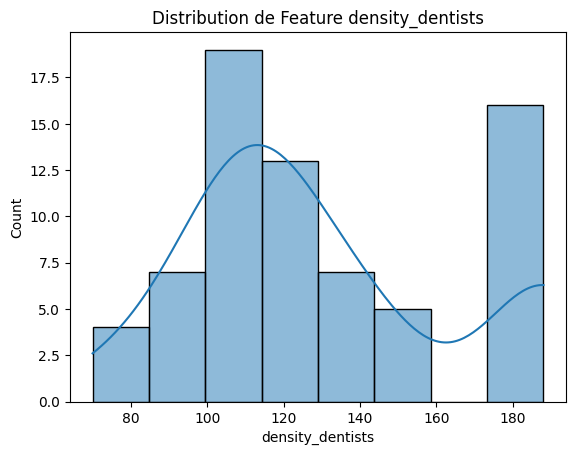

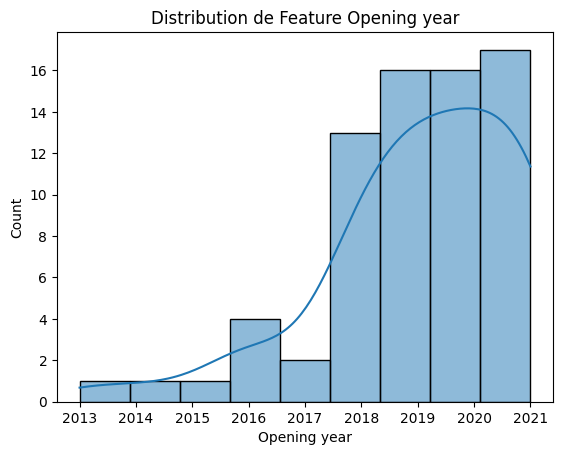

In [ ]:
#Outlier dans revenue (14,6), patiens yearly growth, doctors in the catchment area
for c in data.columns:
  sns.histplot(data[c], kde=True)
  plt.title('Distribution de Feature' +' ' + str(c))
  plt.show()

In [75]:
## We will talk about that imputint strategy later

data_imputed = data.copy()
imputer_zero = SimpleImputer(fill_value = 0, strategy='constant')
data_imputed[(data_imputed['Opening year']== 2021) & (data_imputed['revenue'].isna())] =  imputer_zero.fit_transform(data_imputed[(data_imputed['Opening year']== 2021) \
                                                                                                                      & (data_imputed['revenue'].isna())])

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_without_nan = pd.DataFrame(data_imputed, columns=data.columns)

In [76]:
skewness_stats = data_without_nan.apply(lambda x: skew(x))

# Affichage sous forme de tableau
skewness = pd.DataFrame({
    'Value': skewness_stats
})

skewness

,Value
Latitude,-0.596265
Longitude,-0.167659
revenue,3.712373
r_margin,-0.157672
fte,0.323097
nbr_reviews,0.541063
avg_rating,-0.086229
rent,0.887607
nbr_patients,0.939119
patients_yearly_growth,0.899073


In [77]:
(data_without_nan[data_without_nan['revenue']> 14])

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
69,50.616725,3.133466,15.0,0.19,4.0,46.0,4.891304,3484.0,24675.533216,0.04,9.05954,18853.333333,10.1,23.194949,166.0,55.0,113.0,2019.0


In [78]:
data_without_nan[["Opening year"]].describe()

,Opening year
count,71.000000
mean,2019.084507
std,1.762680
min,2013.000000
25%,2018.000000
50%,2019.000000
75%,2020.000000
max,2021.000000


In [79]:
data_without_nan[["Opening year"]].value_counts()

,count
Opening year,
2021.0,17
2019.0,16
2020.0,16
2018.0,13
2016.0,4
2017.0,2
2013.0,1
2014.0,1
2015.0,1


In [81]:
data_without_nan['revenue'][data_without_nan["fte"]== 0]

,revenue
38,0.2
59,0.0


#### Discussion sur la target à choisir

FTE, R_margin et revenue sont très corrélées

Different strategies can be employed depending on the objectives of the dental center, where m is the margin and r the revenue :

- **Profit Maximization**:
$$
\text{profit} = \text{m} \times \text{r}
$$
- **profit per dentist full-time equivalent** :
$$
\text{Profit per Dentist} = \frac{m \times r}{\text{FTE}}
$$
- **profitability adjusted for key operating costs** :
$$
\text{Adjusted Profitability} = \frac{r \times m}{\text{FTE} + \text{Rent}}
$$
- **Operational efficiency**:
$$
\text{Operational Efficiency} = \text{Margin}
$$
- **Custom perfomance metric by doing a PCA between some previously shared feratures**

<br>

For the purposes of this analysis, we have chosen two main objectives: profit per dentist, acknowledging the flat hierarchy in dental practices where each dentist has a stake in the business and the goal is to increase gain for each dentist, and absolute margin, which aims to optimize the efficiency of the center. Given the business context, creating a PCA to represent a global performance feature would not be appropriate, as it may lack clarity and be difficult to explain.

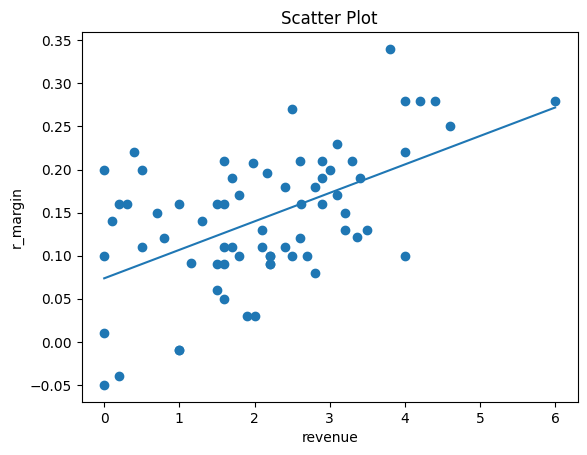

In [ ]:
## Scatter entre revenue et r_margin
plt.scatter(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69))
plt.plot(np.unique(data_without_nan['revenue'].drop(69)), np.poly1d(np.polyfit(data_without_nan['revenue'].drop(69), data_without_nan['r_margin'].drop(69), 1))(np.unique(data_without_nan['revenue'].drop(69))))
plt.xlabel('revenue')
plt.ylabel('r_margin')
plt.title('Scatter Plot')
plt.show()

In [ ]:
#Create a target to see correlation
#data['target'] = data_transform1['revenue'] * data_transform1['r_margin']
#data_transform1.drop(69).plot.scatter(x='fte', y='revenue')

<Axes: xlabel='revenue', ylabel='Count'>

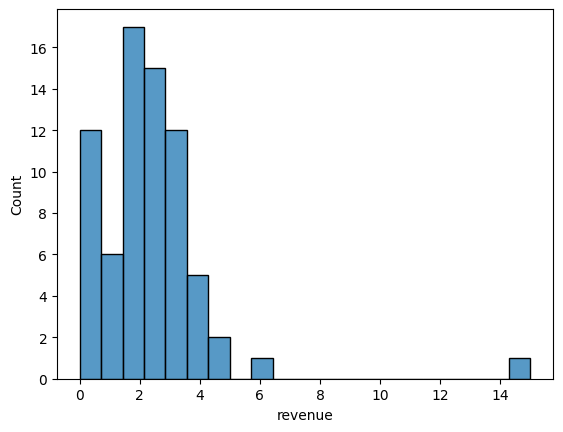

In [ ]:
sns.histplot(data_without_nan['revenue'])

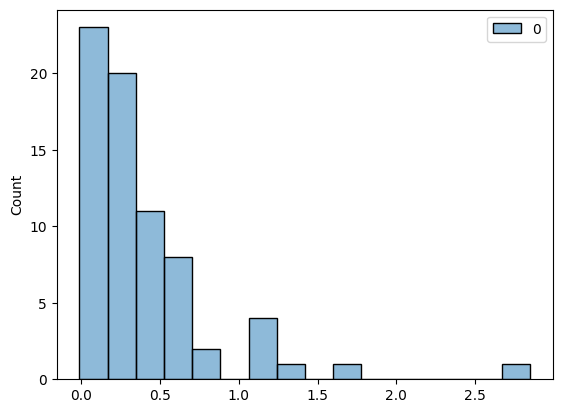

In [ ]:
sns.histplot(pd.DataFrame(data_without_nan['revenue'] * data_without_nan['r_margin']))
plt.show()

In [ ]:
#augmenter les données avec du réel !
## Voir si revenue = Nan <=> revnue = 0 cf data creation

## Question 2

Which variables **explain the largest share of center performance?** Are they rather linked to operational center performance or to the center's catchment area? Please try to **build a small supervised machine learning model** to support your findings.

Before starting the analysis, we assume that certain variables, such as the duration of consultations, the number of reviews, and possibly **internal aspects** like service quality, strongly influence the performance of the centers. This leads us to place particular importance on the internal factors of the firm. Moreover, **some variables are strongly correlated with performance (such as revenue and FTE). Therefore, it is important to consider them not as training variables, but rather as target variables.**
<br>

At the same time, it is quite evident that the location of the firm—whether in a low-density region or an oversaturated area—will also impact its performance. This raises an open question regarding the relative importance of internal versus external factors. While we expect **internal factors to play a significant role**, it is important to consider that the data may be somewhat **biased** in favor of these internal elements. Dentists often recognize the critical importance of selecting an optimal location for their practice, which could skew the data towards internal influences. <br>

To validate this intuition, we will apply supervised models. These models will help us quantify the importance of the various variables and confirm (or refute) the influence of internal factors. We will specifically rely on **feature importance** calculated by the models (**XGBoost Regressor**).

### Preprocessing and Data Engineering

Although our exercise is not a prediction task and, therefore, preprocessing may not seem as critical, I decided to pay particular attention to it out of a concern for detail. This is especially important when dealing with a limited dataset like ours, as ensuring the data is as homogeneous as possible is essential for robust analysis. <br><br>

The goal of identifying the most important features must remain a priority. While we might be tempted to perform PCA on the density features—combining the three different features into one—due to the relatively large number of variables compared to the length of the dataset, it is crucial to remember that **our objective is not prediction, but rather the evaluation of features**. Therefore, applying PCA in this context could prove to be more detrimental than beneficial. <br><br>



That being said, we first addressed the missing values using two imputation strategies. The first strategy involved filling missing values with zero when the firm was newly established at the time of the study (2021). This approach is logical, as it accurately reflects the absence of recorded data for firms that had not yet generated revenue. The second strategy employed K-Nearest Neighbors (K-NN) imputation. This method is particularly suitable in our context, especially since we do not have significant concerns regarding computational demand given the size of our dataset.

In [82]:
operational_features = ['revenue', 'r_margin' 'fte', 'nbr_reviews', 'avg_rating','nbr_patients','Opening year']
catchment_features = [
    'rent','patients_yearly_growth','patients_over_65','median_revenue',
    'r_unemployment','r_poverty','density_doctors','density_pharmacists','density_dentists'
]

In [83]:
## Missing values : KNNImputer, et si data de création = 2021, remplacer le tout par zéro

imputer_zero = SimpleImputer(fill_value = 0, strategy='constant')
data[(data['Opening year']== 2021) & (data['revenue'].isna())] =  imputer_zero.fit_transform(data[(data['Opening year']== 2021) \
                                                                                                                      & (data['revenue'].isna())])

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_transform = pd.DataFrame(data_imputed, columns=data.columns)

We have created a new feature: Duration. This decision was made because the information regarding the year when the revenue measurement was taken (2021) was not adequately represented in our data frame. Specifically, it was embedded in the name of an existing feature, which we have now renamed. Additionally, the opening year alone does not seem sufficient to explain performance effectively. Therefore, we created the Duration feature, defined as $$duration = 2021 - Opening Year$$ <br>
Furthermore, latitude and longitude alone do not provide directly usable data for the model. Instead, it would be more insightful to calculate the distance to the city center, using the Haversine formula, for instance. This approach allows us to derive meaningful spatial relationships that can enhance our analysis. Given the lack of additional indicators, I also decided to drop these features.




In [84]:
##Feature engineering :

data_transform['duration'] = 2021 - data_transform['Opening year']
data_transform['duration'].describe()
data_transform = data_transform.drop('Opening year', axis = 1)

In [85]:
data_transform = data_transform.drop(['Latitude', 'Longitude'], axis = 1)

Eventually, we focused on data skewness and outliers, as they are well-known to impact model performance. One of the few transformations we were able to implement was addressing this issue. Although Box-Cox and logarithmic transformations initially appeared suitable, they presented challenges due to the possibility of certain features having zero values (such as revenue). Additionally, clipping values at a small threshold like 1e-5 seemed inadequate given the units involved; for instance, 1e-3 of a million still corresponds to 1,000 euros, which is significant in our context.

In [86]:
#As in Question 1
skewness_stats = data_transform.apply(lambda x: skew(x))
skewness = pd.DataFrame({
    'Value': skewness_stats
})
skewness

,Value
revenue,3.645731
r_margin,-0.147241
fte,0.231228
nbr_reviews,0.544403
avg_rating,-3.606896
rent,0.887607
nbr_patients,0.939119
patients_yearly_growth,0.899073
patients_over_65,1.770359
median_revenue,1.421315


In [87]:
## yeojohnson_columns des features skewed :
yeojohnson_columns = skewness[abs(skewness['Value']) > 1.5].index
for column in yeojohnson_columns:
    data_transform[column] = stats.yeojohnson(data_transform[column])[0]

In [88]:
skewness_stats = data_transform[yeojohnson_columns].apply(lambda x: skew(x))

# Affichage sous forme de tableau
skewness_yj = pd.DataFrame({
    'Value': skewness_stats
})

skewness_yj

,Value
revenue,0.011947
avg_rating,-0.100654
patients_over_65,0.000358
r_poverty,0.043240
density_doctors,0.013127


Here, we can observe the improvement, with the data appearing significantly less skewed.



### Création de la target et model build

Given the limited size of our dataset, we conducted a grid search using relatively low values for the number of estimators and maximum depth. This approach is intended to avoid overfitting and ensure that our model generalizes well to unseen data.

<br>

We use the **XGBoost Regressor** because boosting techniques often yield better results on test sets when dealing with small datasets.

<br>

Regarding the metrics, even though we reduced the skewness of the data, we aimed to avoid metrics that are heavily impacted by outliers, such as MSE, especially considering the limited length of the dataset. Therefore, **we chose R² and MAE** as our evaluation metrics. R² provides an indication of how well our model explains the variability of the target variable, while MAE offers a straightforward measure of average error, making them more robust choices for our analysis.

####Premiere stratégie - profit per dentist full-time equivalent

Note that **if FTE is null**, the profit per dentist is not defined. However, logically, if the FTE is null, there is no reason for the profit for dentists to be different from **zero**. Therefore, we’ve transformed y based on this reasoning.

In [189]:
data_transform1 = data_transform.copy()

In [190]:
data_transform1['target'] = (data_transform1['revenue'] * data_transform1['r_margin'])  /data_transform1['fte']

X = data_transform1.drop(['target','revenue','r_margin',"fte"], axis = 1)
y = data_transform1['target'].fillna(0).replace([np.inf, -np.inf], 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [191]:
model = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [3,5,7,10,25,50],   # Example values for n_estimators
    'max_depth': [2,3,4,5]     # Example values for max_depth
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_median_absolute_error', verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params= grid_search.best_params_
best_score = -grid_search.best_score_  # Convert from negative MSE

print("Best Parameters:", best_params)
print(f"Best Mean Absolute Error: {best_score:.4f}")

y_pred = grid_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 63 folds for each of 24 candidates, totalling 1512 fits
Best Parameters: {'max_depth': 4, 'n_estimators': 3}
Best Mean Absolute Error: 0.0183
R² Score: -0.2079


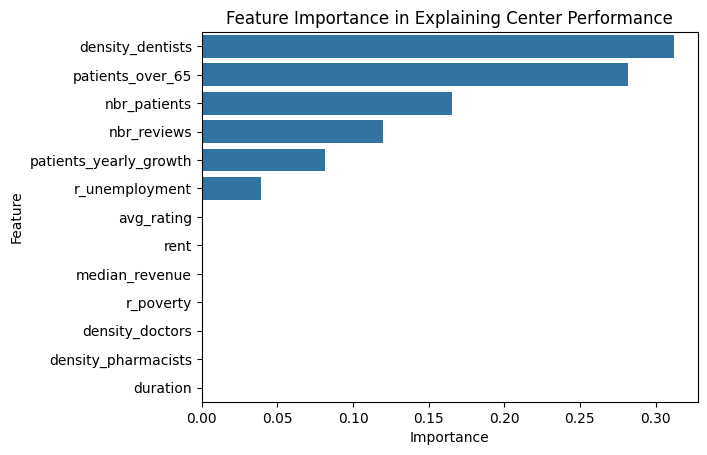

In [194]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

In [ ]:
## Voir pour faire juste du k fold au lieu de cross validation with grid search

##### Conclusion

In [ ]:
print(importance_df)

                   Feature  Importance
0                      fte    0.182477
6         patients_over_65    0.160698
11                duration    0.152137
1              nbr_reviews    0.134772
4             nbr_patients    0.076457
7           median_revenue    0.065326
5   patients_yearly_growth    0.059287
8           r_unemployment    0.049626
10                 density    0.042334
9                r_poverty    0.041692
3                     rent    0.035193
2               avg_rating    0.000000


#### deuxième stratégie - Operational Efficiency

In [182]:
data_transform2 = data_transform.copy()

In [184]:
X = data_transform2.drop(['r_margin',], axis = 1)
y = data_transform2['r_margin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [185]:
model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [3,5,7,8,9,10,50],   # Example values for n_estimators
    'max_depth': [2,3,4,5]     # Example values for max_depth
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_median_absolute_error', verbose=1)

# Fit the grid search
grid_search2.fit(X_train, y_train)

best_model2 = grid_search2.best_estimator_
best_params2= grid_search2.best_params_
best_score2 = -grid_search2.best_score_  # Convert from negative MAE

print("Best Parameters:", best_params2)
print(f"Best Mean Absolute Error : {best_score2:.4f}")

y_pred = grid_search2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 63 folds for each of 28 candidates, totalling 1764 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 5}
Best Mean Absolute Error : 0.0537
R² Score: -0.1875


In [187]:
model = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [3,5,7,10,25,50],   # Example values for n_estimators
    'max_depth': [2,3,4,5]     # Example values for max_depth
}

# Define LOOCV
loo = LeaveOneOut()

# Setup GridSearchCV with LOOCV
grid_search2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_median_absolute_error', verbose=1)

# Fit the grid search
grid_search2.fit(X_train, y_train)

best_model2 = grid_search2.best_estimator_
best_params2= grid_search2.best_params_
best_score2 = -grid_search2.best_score_  # Convert from negative MSE

print("Best Parameters:", best_params2)
print(f"Best Mean Absolute Error: {best_score2:.4f}")

y_pred = grid_search2.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 63 folds for each of 24 candidates, totalling 1512 fits
Best Parameters: {'max_depth': 4, 'n_estimators': 50}
Best Mean Absolute Error: 0.0477
R² Score: 0.2749


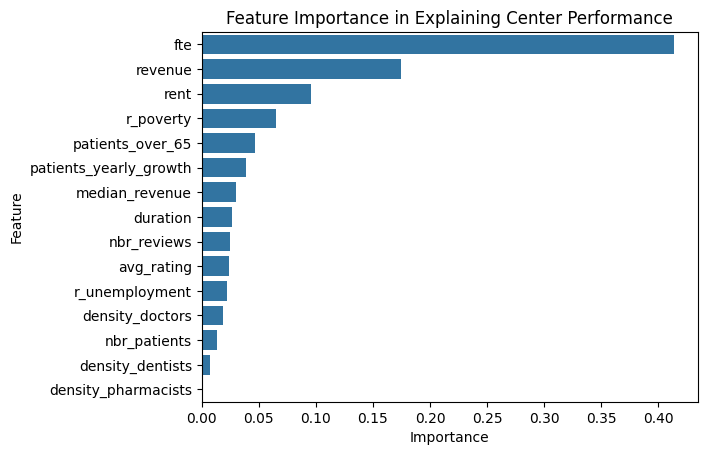

In [186]:
feature_importances = best_model2.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

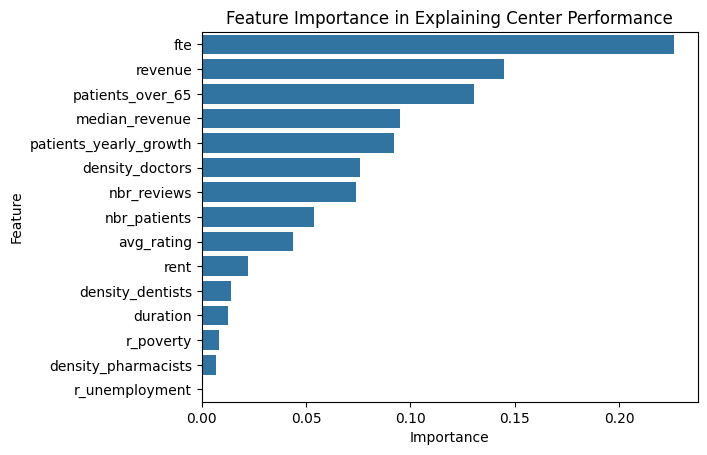

In [188]:
feature_importances = best_model2.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Center Performance')
plt.show()

In [ ]:
#####Deuxieme modele

##### Conclusion

balbala

Aurait on pu conclure avant d'utiliser ces modeles ?
Parmis les 10 premières (en terme d'importance) variables, 4 sont internes et 6 externes aux cabinets -> premiere conclusion possible   

## Question 3

Use an unsupervised learning technique to **cluster the dental centers**. How would you describe each cluster to the client in business terms?

In [810]:
best_score = -1
best_k = 0

for k in range(2, 9):

    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = clustering.fit_predict(data_transform)


    score = silhouette_score(X, labels)
    print(f"Nombre de clusters: {k}, Score de silhouette: {score}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score de silhouette de : {best_score}")

Nombre de clusters: 2, Score de silhouette: 0.5146003695177668
Nombre de clusters: 3, Score de silhouette: 0.5985354973898934
Nombre de clusters: 4, Score de silhouette: 0.5175234882530046
Nombre de clusters: 5, Score de silhouette: 0.5629594893273848
Nombre de clusters: 6, Score de silhouette: 0.5184089438894427
Nombre de clusters: 7, Score de silhouette: 0.5218296452205539
Nombre de clusters: 8, Score de silhouette: 0.5057845662134112
Meilleur nombre de clusters : 3 avec un score de silhouette de : 0.5985354973898934


In [811]:
clustering = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(data_transform)

# Ajouter les labels aux données pour analyse
df = pd.DataFrame(data_transform, columns=data_transform.columns)  # Remplacez par les noms réels de vos colonnes
df['Cluster'] = labels

In [812]:
# Regarder c'est quelle variable qui a été la plus déterminante

p_values = {}

for column in df.columns[:-1]:  # Ignorez la première colonne qui est 'Population'
    groups = [group[column].values for name, group in df.groupby('Cluster')]
    F_stat, p_value = stats.f_oneway(*groups)
    p_values[column] = p_value

# Convertir en DataFrame pour faciliter le tri
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [813]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [814]:
p_values_df

,Variable,p_value
6,nbr_patients,2.687734e-29
5,rent,5.856150e-19
14,density_dentists,1.832401e-16
13,density_pharmacists,5.849854e-14
9,median_revenue,5.960550e-09
12,density_doctors,3.394591e-06
10,r_unemployment,1.388592e-05
11,r_poverty,6.380005e-03
3,nbr_reviews,2.974135e-02
7,patients_yearly_growth,4.392728e-02


In [ ]:
## Ie celle qui remet le plus en cause l'hypothèse nulle est la variable nbr_patient in catchment area !

In [ ]:
most_discriminant_variable = p_values_df.iloc[0]
print(f"Variable la plus discriminante : {most_discriminant_variable['Variable']}, p-value : {most_discriminant_variable['p_value']}")

Variable la plus discriminante : nbr_patients, p-value : 2.687734139649366e-29


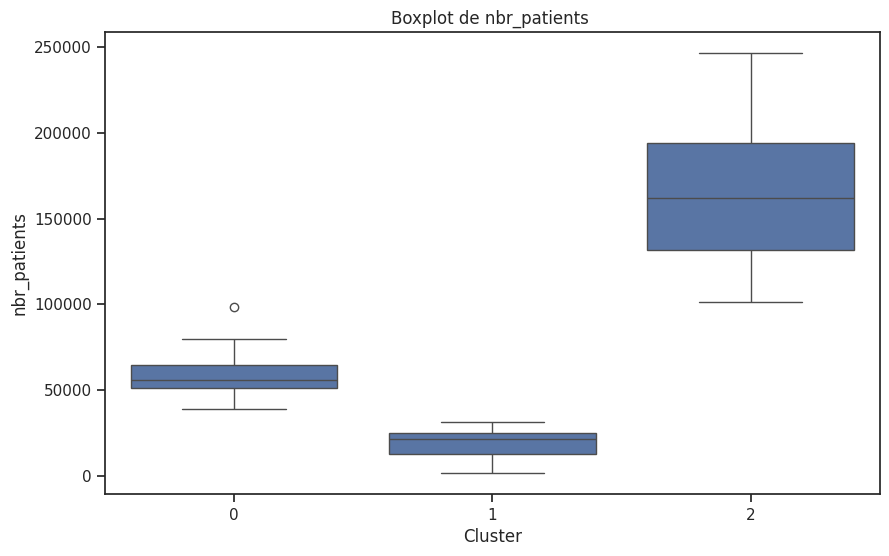

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=most_discriminant_variable['Variable'], data=df)
plt.title(f'Boxplot de {most_discriminant_variable["Variable"]} ')
plt.show()

Les cabinets seront donc à distinguer en trois catégories possibles :

- Les centres à forte demande, situé dans des zones densément peuplées, ils ont beaucoup de demande.
- Les centres en développement, certes dans une zone moins peuplée, ils ont tout de même un fort potentiel de développement
- Centres spécialisés à faible densité : Situés dans des zones de faiblesdensitées de population, ces centres se distinguent souvent par une spécialisation

## Question 4

Let's **enrich our dataset** with additional data on competition. Download the following file providing an overview of all medical institutions in France with their geo coordinates and convert it to a clean dataframe: https://www.data.gouv.fr/fr/datasets/r/98f3161f-79ff-4f16-8f6a-6d571a80fea2.

Perform the necessary **filters to separate dental centers** from the other institutions.

**Reproject the geo coordinates** to the ESPG:4326 coordinate reference system (same as the coordinates in the dental center dataset).

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

In [ ]:
##Modification des entetes en local -> faire de facon automatisé/python
## Le data set est composé de deux parties, une structureet (info structuelle) l'autre géolocalisation (info géo)
##Dabord filtrer en dentaire ensuite séparation et changement de base et ensuite merge -> moins de place prise
##Faire le renommage des colonnes ici et pas en local !
##La selection par Code APE semble trop restrictif. En effet, on semble s'interesser à tout type de concurrence.
##Donc un cabinet qui exerce, les soins dentaires en activité secondaire ne sera pas garder (code APE = Activité principale).
## Raison sociale avec un E !

In [ ]:
data_concu = pd.read_csv('etalab-cs1100507-stock-20240909-0338(3).csv',sep = ';').reset_index().drop("2024-09-09",axis =1)

<ipython-input-560-c6cd24418443>:1: DtypeWarning: Columns (1,2,3,6,8,9,10,11,13,14,15,19,21,23,25,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data_concu = pd.read_csv('etalab-cs1100507-stock-20240909-0338(3).csv',sep = ';').reset_index().drop("2024-09-09",axis =1)


In [ ]:
data_concu.columns = ['finess', 'FinessET', 'FinessEJ', 'RaisonSociale', 'RaisonSocialLongue',
       'ComplementRaisonSociale', 'ComplementDistribution', 'NumRue',
       'TypeRue', 'NomRue', 'c6', 'c7', 'c8', 'numDep', 'dep',
       'LigneAcheminement', 'Telephone', 'Telecopie',
       'CodeCategorieEtablissement', 'NomCategorieEtablissement',
       'NumCategorieAgragat', 'LieblleCategorieAgregat', 'NumleroSiret',
       'CodeAPE', 'CodeMFT', 'Libelle MFT', 'Code SPH', 'libelle SPH',
       'dateOuverture', 'Date d’autorisation',
       'Date de mise à jour de la structure']
data_concu.columns

Index(['finess', 'FinessET', 'FinessEJ', 'RaisonSociale', 'RaisonSocialLongue',
       'ComplementRaisonSociale', 'ComplementDistribution', 'NumRue',
       'TypeRue', 'NomRue', 'c6', 'c7', 'c8', 'numDep', 'dep',
       'LigneAcheminement', 'Telephone', 'Telecopie',
       'CodeCategorieEtablissement', 'NomCategorieEtablissement',
       'NumCategorieAgragat', 'LieblleCategorieAgregat', 'NumleroSiret',
       'CodeAPE', 'CodeMFT', 'Libelle MFT', 'Code SPH', 'libelle SPH',
       'dateOuverture', 'Date d’autorisation',
       'Date de mise à jour de la structure'],
      dtype='object')

In [ ]:
data_geo = data_concu[data_concu['finess'] == 'geolocalisation'].drop('finess', axis = 1)
data_struct = data_concu[data_concu['finess'] == 'structureet'].drop('finess', axis = 1)

In [ ]:
print(len(data_geo),len(data_struct))

100462 100462


In [ ]:
data_geo.to_csv('data_geo.csv')
data_struct.to_csv('data_struct.csv')

####Prepo data_geo

In [ ]:
data_geo = data_geo.drop(['ComplementRaisonSociale','ComplementDistribution','c6','c7','Telephone',\
                            'Telecopie','NumleroSiret','CodeMFT','Libelle MFT','Code SPH','libelle SPH',\
                          "NomRue",'TypeRue','NumRue','c8','numDep','dep','LigneAcheminement','CodeCategorieEtablissement',\
                          'NomCategorieEtablissement','NumCategorieAgragat','NumCategorieAgragat','LieblleCategorieAgregat',\
                          'CodeAPE','dateOuverture','Date d’autorisation','Date de mise à jour de la structure'], axis = 1)

In [ ]:
data_geo.rename(columns={'FinessEJ' : 'coordonnée_x', 'RaisonSociale': 'coordonnée_y','RaisonSocialLongue' : "systeme" ,'FinessET': 'finess_geo'}, inplace=True)

In [ ]:
data_geo['systeme'] = data_geo[['systeme']].astype(str)

In [ ]:
data_geo['systeme'] = data_geo['systeme'].apply(lambda x: x.split(',')[-1])

In [ ]:
map_systeme = {
  'LAMBERT_93_METROPOLE' : 'EPSG:2154',
  'UTM_N20_ANTILLES' : 'EPSG:4559',
  'UTM_N22_GUYANE' : 'EPSG:2972',
  'UTM_S40_LA_REUNION' : 'EPSG:2975',
  'UTM_N21_STPIERRE-MIQUELON' : 'EPSG:4467',
  'UTM_S38_MAYOTTE' : 'EPSG:4471'
            }

def system_convertor(x):
    src_epsg = map_systeme.get(x['systeme'])
    if src_epsg is None:
        print(x['systeme'])
        return None, None
    transformer = Transformer.from_crs(src_epsg, "EPSG:4326", always_xy=True)
    return transformer.transform(x['coordonnée_x'], x['coordonnée_y'])

data_geo['(longitude,latitude)'] = data_geo.apply(system_convertor, axis=1)
data_geo = data_geo.drop(['coordonnée_x', 'coordonnée_y', 'systeme'], axis=1)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [ ]:
data_geo["longitude"] = data_geo["(longitude,latitude)"].apply(lambda x: x[0])
data_geo["latitude"] = data_geo["(longitude,latitude)"].apply(lambda x: x[1])
data_geo = data_geo.drop('(longitude,latitude)', axis = 1)

In [ ]:
data_geo.head()

,finess_geo,longitude,latitude
100462,10000024,5.208387,46.222647
100463,10000032,5.679892,45.748331
100464,10000065,4.771957,45.941074
100465,10000081,6.057731,46.322338
100466,10000099,5.194669,45.906630


####Prepo struct

In [ ]:
## Cat aggregation, nom, NumCategorieAgragat,c8

On remarque que la selection par Code APE semble trop restrictif. En effet, on semble s'interesser à tout type de concurrence.
Donc un cabinet qui exerce, les soins dentaires en activité secondaire ne sera pas garder (code APE = Activité principale).
Prenons l'exemple du centre de soin de numero finess ET : 380027151.

In [ ]:
data_struct[data_struct["FinessET"]== 380027151]

,FinessET,FinessEJ,RaisonSociale,RaisonSocialLongue,ComplementRaisonSociale,ComplementDistribution,NumRue,TypeRue,NomRue,c6,...,LieblleCategorieAgregat,NumleroSiret,CodeAPE,CodeMFT,Libelle MFT,Code SPH,libelle SPH,dateOuverture,Date d’autorisation,Date de mise à jour de la structure
34519,380027151,380027144,CENTRE DE SANTE DENTAIRE VERTUO,CENTRE DE SANTE DENTAIRE VERTUO,NaN,NaN,1.0,R,DES ABATTOIRS,NaN,...,Centres de Santé,9.195290e+13,8899B,36.0,Tarifs conventionnels assurance maladie,NaN,NaN,2023-09-04,2023-03-03,2023-09-04


Il est inscrit avec un code APE 8899B, ce qui correspond à Action sociale sans hébergement n.c.a. et non à une pratique dentaire (code APE ; 8623Z). Alors qu'il est bel et bien un centre de santé dentaire. De la même manière, cela ne semble par être une bonne solution de filtrer sur la Catégorie d'établissement ou encore le numéro de catégorie d'agrégat.  <br>
**Cependant**, il est a noter que cela dépend encore une fois de la stratégie du cabinet.  <br><br>
Dans le cadre de cet exercice, et en abscence d'indication supplémentaire, nous trierons donc par le nom de la raison sociale. Si il contient le mot dentaire ou dent, on le retiendra, sinon on le filtre. <br>
En fonctionnant ainsi, on obtient 1126 cabinets supplémentaires et non 760 en triant avec le code APE.

In [ ]:
data_struct.head()

,finess_geo,FinessEJ,RaisonSocialLongue,dateOuverture,Date d’autorisation,Date de mise à jour de la structure,adresse
457,10011468,10011450,CENTRE DE SANTE DENTAIRE FERNEY-VOLTAIRE,2019-07-15,2018-07-19,2024-01-12,26.0 AV VOLTAIRE
513,10012425,920037751,CENTRE DE SANTE DENTAIRE CLEMENCEAU,2021-12-01,2021-08-12,2021-12-01,12.0 AV CLEMENCEAU
516,10012482,10012474,CENTRE DE SANTE DENTAIRE D'OYONNAX,2021-10-15,2021-09-09,2023-09-15,31.0 BD LOUIS DUPUY
525,10012656,10012649,CENTRE DE SANTE DENTAIRE DE SAINT GENIS POUILLY,2022-08-18,2022-08-18,2023-08-31,34.0 R DU MONT BLANC
550,10013084,10013076,CENTRE DE SANTE MEDICO-DENTAIRE VALSERHONE,2023-10-17,2023-10-17,2023-10-17,25.0 R DE LA REPUBLIQUE


In [ ]:
data_struct['NumRue'] = data_struct['NumRue'].astype(str)
data_struct['TypeRue'] = data_struct['TypeRue'].astype(str)
data_struct['NomRue'] = data_struct['NomRue'].astype(str)

data_struct['adresse'] = data_struct[['NumRue','TypeRue', 'NomRue']].agg(' '.join, axis=1)

data_struct = data_struct.drop(['NumRue','TypeRue', 'NomRue'],axis = 1)

In [ ]:
data_struct.rename(columns={'FinessET' : 'finess_geo'}, inplace=True)

In [ ]:
data_struct = data_struct.drop(['ComplementRaisonSociale','ComplementDistribution','c6','c7','numDep','Telephone',\
                                'Telecopie','NumleroSiret','CodeMFT','Libelle MFT','Code SPH','libelle SPH'], axis = 1)

In [ ]:
data_struct = data_struct[data_struct['RaisonSocialLongue'].str.contains('dentaire|dent', case=False, na=False)]
data_struct = data_struct.drop(['c8','CodeCategorieEtablissement','NomCategorieEtablissement','NumCategorieAgragat', \
                                      'LieblleCategorieAgregat','CodeAPE','RaisonSociale','dep','LigneAcheminement',], axis = 1)

In [ ]:
data_struct.head()

,finess_geo,FinessEJ,RaisonSocialLongue,dateOuverture,Date d’autorisation,Date de mise à jour de la structure,adresse
457,10011468,10011450,CENTRE DE SANTE DENTAIRE FERNEY-VOLTAIRE,2019-07-15,2018-07-19,2024-01-12,26.0 AV VOLTAIRE
513,10012425,920037751,CENTRE DE SANTE DENTAIRE CLEMENCEAU,2021-12-01,2021-08-12,2021-12-01,12.0 AV CLEMENCEAU
516,10012482,10012474,CENTRE DE SANTE DENTAIRE D'OYONNAX,2021-10-15,2021-09-09,2023-09-15,31.0 BD LOUIS DUPUY
525,10012656,10012649,CENTRE DE SANTE DENTAIRE DE SAINT GENIS POUILLY,2022-08-18,2022-08-18,2023-08-31,34.0 R DU MONT BLANC
550,10013084,10013076,CENTRE DE SANTE MEDICO-DENTAIRE VALSERHONE,2023-10-17,2023-10-17,2023-10-17,25.0 R DE LA REPUBLIQUE


####Merge

In [ ]:
data2 = pd.merge(data_geo, data_struct, on='finess_geo', how='inner') #drop dans geo

In [ ]:
print(len(data2))

1104


In [ ]:
data2.head()

,finess_geo,longitude,latitude,FinessEJ,RaisonSocialLongue,dateOuverture,Date d’autorisation,Date de mise à jour de la structure,adresse
0,10011468,6.111825,46.257763,10011450,CENTRE DE SANTE DENTAIRE FERNEY-VOLTAIRE,2019-07-15,2018-07-19,2024-01-12,26.0 AV VOLTAIRE
1,10012425,5.651367,46.255845,920037751,CENTRE DE SANTE DENTAIRE CLEMENCEAU,2021-12-01,2021-08-12,2021-12-01,12.0 AV CLEMENCEAU
2,10012482,5.650842,46.258150,10012474,CENTRE DE SANTE DENTAIRE D'OYONNAX,2021-10-15,2021-09-09,2023-09-15,31.0 BD LOUIS DUPUY
3,10012656,6.027794,46.255077,10012649,CENTRE DE SANTE DENTAIRE DE SAINT GENIS POUILLY,2022-08-18,2022-08-18,2023-08-31,34.0 R DU MONT BLANC
4,10013084,5.827317,46.107727,10013076,CENTRE DE SANTE MEDICO-DENTAIRE VALSERHONE,2023-10-17,2023-10-17,2023-10-17,25.0 R DE LA REPUBLIQUE


In [ ]:
data2.to_csv('data2.csv')

On peut donc rajouter 1104 entrées supplémentaires, ce qui ne semble pas abérrant en croisant les informations sur internet.

## Question 5

Let's **assess competitive intensity** around the dental centers. First **draw a circle with a 500 meter radius** around each of the 71 dental center (under the form of a POLYGON). We will refer to these shapes as center catchment areas.
Then, **compute the number of competitors**, i.e. dental centers from the dataset you built in question 4 within each catchment area. Name this variable competitive intensity.

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

To compute the competitive intensity we can count using a spatial join, to see how many other dental centers fall within each center's 500-meter catchment area. We have to keep in mind that how many other cabinet are there in the catchment is not in its own the competitive intensity parameter. Indeed, it can also depends of the density of population in this area for example.

In [692]:
data = pd.read_excel('20231124_dental_center_data 1.xlsx')

In [ ]:
def create_catchment_area(x):
    point = Point(x['Longitude'], x['Latitude'])
    catchment_area = point.buffer(500)
    return catchment_area

#data['geometry'] = data.apply(create_catchment_area, axis=1)

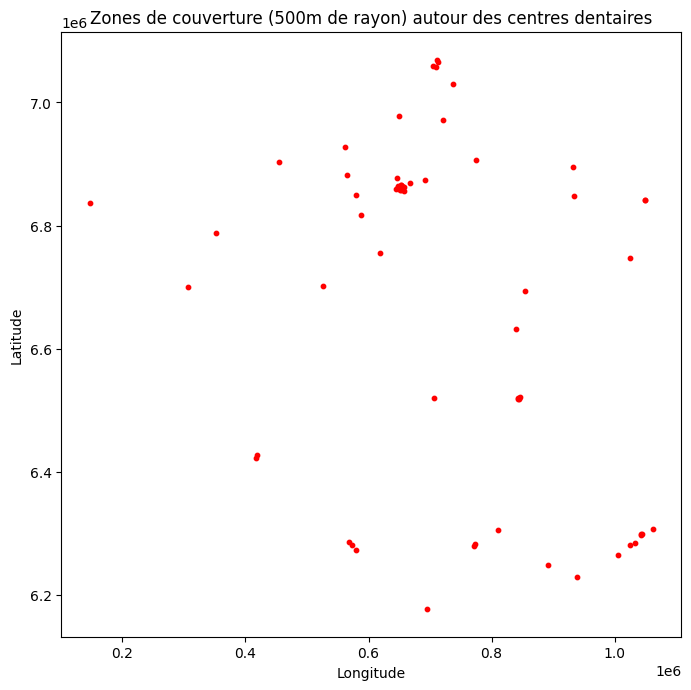

In [702]:
#ca m'apparait gros comme cercle
gdf_centers = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.Longitude, data.Latitude),
    crs="EPSG:4326"
)

gdf_centers = gdf_centers.to_crs("EPSG:2154")
gdf_centers['buffer'] = gdf_centers.geometry.buffer(500) #On ne voit pas le cercle de 500m, trop petit ...
fig, ax = plt.subplots(figsize=(8, 8))
gdf_centers['buffer'].plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)

gdf_centers.plot(ax=ax, color='red', markersize=10)

plt.title("Zones de couverture (500m de rayon) autour des centres dentaires")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

In [724]:
#Create spatial point corresponding to the location of competitor and then spacially join them if they are within a polygon from gdf_centers
gdf_competitors = gpd.GeoDataFrame(
    data2, geometry=gpd.points_from_xy(data2.longitude, data2.latitude), crs="EPSG:4326"
)
gdf_competitors = gdf_competitors.to_crs("EPSG:2154")

gdf_centers.set_geometry("buffer", inplace=True)

#Le competiteur est join si son point est inclus dans le cercle
join_result = gpd.sjoin(gdf_centers, gdf_competitors, how="left")

competitive_intensity = join_result.groupby('ID').size()

gdf_centers['competitive_intensity'] = gdf_centers['ID'].map(competitive_intensity).fillna(0)

In [723]:
print(gdf_centers.crs,gdf_competitors.crs)

EPSG:2154 EPSG:2154


In [728]:
print(gdf_centers.competitive_intensity.describe())

count    71.000000
mean      1.704225
std       0.962057
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: competitive_intensity, dtype: float64


In [735]:
gdf_centers[['competitive_intensity']].value_counts()

,count
competitive_intensity,
1,42
3,13
2,12
4,4


## Question 6

Now let's **perform the explanatory analysis of question 2 and the clustering of question 3 again**, taking competitive intensity into account. Do the results change, and if so how and why?

Because of consistency, I'm using the same DataFrame, data_transform, that I did my preliminary analysis on before.

In [772]:
data_transform2 = data_transform.copy()

In [773]:
data_transform2['competitive_intensity'] = gdf_centers['competitive_intensity']

In [774]:
data_transform2.head()

,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density,duration,competitive_intensity
0,1.279951,0.18,7.0,190.0,3.552632,5731.0,58874.899010,-0.24,0.960656,1.234328,0.360985,3.556194,-1.011343,2.0,1
1,1.342566,0.21,9.0,153.0,4.039216,2708.0,39687.660222,0.18,0.963138,1.234275,0.361343,4.211379,-0.959449,2.0,4
2,1.538882,0.21,10.0,163.0,4.288344,4751.0,25370.677794,-0.68,1.008128,1.234318,0.361601,3.728490,-0.467960,3.0,4
3,1.213822,0.09,10.0,145.0,4.158621,3205.0,6945.136108,1.83,0.946844,1.234327,0.361064,2.784920,-0.044760,1.0,1
4,1.430689,0.21,8.0,63.0,4.650794,3707.0,6992.074760,1.08,0.929512,1.234272,0.360863,5.008497,-0.156594,2.0,2


### Explanatory analysis

In [ ]:
# your code here



### Clustering

In [775]:
best_score = -1
best_k = 0

for k in range(2, 9):

    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = clustering.fit_predict(data_transform2)


    score = silhouette_score(X, labels)
    print(f"Nombre de clusters: {k}, Score de silhouette: {score}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score de silhouette de : {best_score}")

Nombre de clusters: 2, Score de silhouette: 0.5146003695177668
Nombre de clusters: 3, Score de silhouette: 0.5985354973898934
Nombre de clusters: 4, Score de silhouette: 0.5175234882530046
Nombre de clusters: 5, Score de silhouette: 0.5629594893273848
Nombre de clusters: 6, Score de silhouette: 0.5184089438894427
Nombre de clusters: 7, Score de silhouette: 0.5218296452205539
Nombre de clusters: 8, Score de silhouette: 0.5057845662134112
Meilleur nombre de clusters : 3 avec un score de silhouette de : 0.5985354973898934


In [776]:
clustering = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(data_transform2)

# Ajouter les labels aux données pour analyse
df2 = pd.DataFrame(data_transform2, columns=data_transform2.columns)  # Remplacez par les noms réels de vos colonnes
df2['Cluster'] = labels

In [777]:
# Regarder c'est quelle variable qui a été la plus déterminante

p_values = {}

for column in df2.columns[:-1]:  # Ignorez la première colonne qui est 'Population'
    groups = [group[column].values for name, group in df2.groupby('Cluster')]
    F_stat, p_value = stats.f_oneway(*groups)
    p_values[column] = p_value

# Convertir en DataFrame pour faciliter le tri
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [778]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [779]:
p_values_df

,Variable,p_value
6,nbr_patients,2.687734e-29
5,rent,5.856150e-19
12,density,3.396670e-14
9,median_revenue,5.960550e-09
10,r_unemployment,1.388592e-05
11,r_poverty,6.380005e-03
3,nbr_reviews,2.974135e-02
7,patients_yearly_growth,4.392728e-02
8,patients_over_65,6.025005e-02
0,revenue,1.310480e-01


Finalement, le nombre de patients dans la zone est encore une fois la variable la plus déterminante, quand bien même on a pris en compte le nombre de cabinet qui peuvent concurrencer le cabinet.

## Question 7

**Summarize your findings** in business terms and formulate a recommendation on how to improve the overall dental center network performance based on the answers to the previous questions.

**Note: for this question no code is expected**

In [ ]:
# your awnser

